In [10]:
import numpy as np
import gsw
import sys
import xray
import os
from scipy import ndimage
from scipy import linalg
from scipy import io
from netCDF4 import Dataset

import matplotlib.pyplot as plt
from scipy.interpolate import interp2d, RectBivariateSpline
%matplotlib inline

sys.path.append('/home/takaya/sst_analysis/Idealized_Model/')
import gfd

In [11]:
basedir = '/data/scratch/takaya/POP_data/'
# fname = basedir + 'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.0050-0059.timeavg.nc'
fname = os.path.join(basedir, 'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.0050-0059.timeavg.nc')

In [12]:
f = Dataset(fname)
f
#pop = xray.open_mfdataset(fname, decode_times=False, engine="scipy")
#pop

<type 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT data model, file format NETCDF3):
    title: hybrid_v5_rel04_BC5_ne120_t12_pop62
    history: Tue Aug 25 13:14:45 2015: ncra /glade/p/ncgd0001/hybrid_v5_rel04_BC5_ne120_t12_pop62/ocn-hist/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.0050-01.nc /glade/p/ncgd0001/hybrid_v5_rel04_BC5_ne120_t12_pop62/ocn-hist/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.0050-02.nc /glade/p/ncgd0001/hybrid_v5_rel04_BC5_ne120_t12_pop62/ocn-hist/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.0050-03.nc /glade/p/ncgd0001/hybrid_v5_rel04_BC5_ne120_t12_pop62/ocn-hist/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.0050-04.nc /glade/p/ncgd0001/hybrid_v5_rel04_BC5_ne120_t12_pop62/ocn-hist/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.0050-05.nc /glade/p/ncgd0001/hybrid_v5_rel04_BC5_ne120_t12_pop62/ocn-hist/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.0050-06.nc /glade/p/ncgd0001/hybrid_v5_rel04_BC5_ne120_t12_pop62/ocn-hist/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.0050-07.nc /gl

In [13]:
lat_start, lat_end = (-60., 50.)
lon_start, lon_end = (5., 345.)
# west, south = (lon_start, lat_start)
# east, north = (west+dlon, south+dlat)

In [14]:
roll = -1080
mask = f.variables['KMT'][:]<=1
tlon = np.roll(np.ma.masked_array(f.variables['TLONG'][:],mask), roll, axis=1)
tlat = np.roll(np.ma.masked_array(f.variables['TLAT'][:],mask), roll, axis=1)
lonrange=np.array([lon_start, lon_end])
latrange=np.array([lat_start, lat_end+5.])
lonmask = (tlon >= lonrange[0]) & (tlon < lonrange[1])
latmask = (tlat >= latrange[0]) & (tlat < latrange[1])
boxidx = lonmask & latmask # this won't necessarily be square
irange = np.where(boxidx.sum(axis=0))[0]
imin_bound, imax_bound = irange.min(), irange.max()
jrange = np.where(boxidx.sum(axis=1))[0]
jmin_bound, jmax_bound = jrange.min(), jrange.max()


npzfile = np.load('interpLatnLon.npz')
print npzfile.files
tlat = npzfile['arr_0']
tlon = npzfile['arr_1']


#Nt, Ny, Nx = SSH.shape
Ny_full = jmax_bound+100-jmin_bound
Nx_full = imax_bound+100-imin_bound

['arr_1', 'arr_0']


In [137]:
mask = np.roll(f.variables['KMT'], -1080, axis=1)[jmin_bound:jmax_bound+100, imin_bound:imax_bound+100] <= 1
Temp = np.roll(f.variables['TEMP'][0], -1080, axis=2)[:, jmin_bound:jmax_bound+100, imin_bound:imax_bound+100]

In [138]:
Lat = np.roll(f.variables['TLAT'][:], -1080, axis=1)[jmin_bound:jmax_bound+100, imin_bound:imax_bound+100]
Lon = np.roll(f.variables['TLONG'][:], -1080, axis=1)[jmin_bound:jmax_bound+100, imin_bound:imax_bound+100]
Salt = np.roll(f.variables['SALT'][0], -1080, axis=2)[:, jmin_bound:jmax_bound+100, imin_bound:imax_bound+100]
PotDen = np.roll(f.variables['PD'][0], -1080, axis=2)[:, jmin_bound:jmax_bound+100, imin_bound:imax_bound+100]
rho0 = f.variables['rho_sw'][:]
g = f.variables['grav'][:]

<matplotlib.colorbar.Colorbar instance at 0x7f12005357e8>

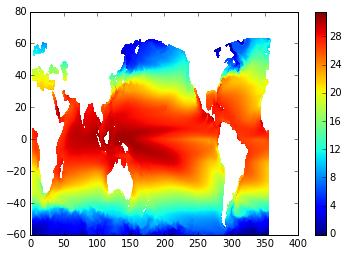

In [139]:
plt.figure()
plt.pcolormesh(tlon[:-100], tlat[:-100], np.ma.masked_array(Temp[0,:-100], mask[:-100]))
plt.colorbar()

In [140]:
Z_mid = f.variables['z_t'][:]*1e-2
Z_midTop150m = f.variables['z_t_150m'][:]*1e-2
# print Z_mid.shape, Z_mid
# print Z_midTop150m.shape, Z_midTop150m  

In [146]:
Z_Top = f.variables['z_w_top'][:]*1e-2
#Z_vectorTop = f.variables['z_w_top'][:]*1e-2
Z_Bot = f.variables['z_w_bot'][:]*1e-2
Z_ToptoBot = np.append(Z_Top,Z_Bot[-1])
# print Z_Top.shape, Z_Top
# #print Z_vectorTop.shape, Z_vectorTop
# print Z_Bot.shape, Z_Bot
# print Z_ToptoBot.shape, Z_ToptoBot

In [148]:
## Compute Pressure from depth

Py, Px = tlat.shape
Pz = len(Z_ToptoBot)
pres_ToptoBot = np.zeros((Pz,Py,Px))
for j in range(Py):
    for i in range(Px):
        pres_ToptoBot[:,j,i] = gsw.p_from_z(-Z_ToptoBot, Lat[j,i]) # [dbar]

In [ ]:
Pz = len(Z_mid)
pres_mid = np.zeros((Pz,Py,Px))
for j in range(Py):
    for i in range(Px):
        pres_mid[:,j,i] = gsw.p_from_z(-Z_mid, Lat[j,i]) # [dbar]

In [ ]:
## Compute absolute salinity

#Salt_Abs = pres.copy()
#for k in range(Salt_Abs.shape[0]):
#    Salt_Abs[k] = gsw.SA_from_SP(Salt[k],pres[k],Lon,Lat)
Salt_Abs = gsw.SA_from_SP(Salt,pres_mid,Lon,Lat)
#Salt_Abs = gsw.SA_from_SP(Salt,100,150,60)

print Salt_Abs.shape, Salt_Abs

(62, 1578, 3523) [[[34.236874718470276 34.23711494281547 34.238029784890976 ...,
   34.322913490676115 34.32121332446114 34.31893054339371]
  [34.237403735398274 34.23767085598381 34.238290617749826 ...,
   34.32241412066603 34.32004715679355 34.317921669713336]
  [34.23826623403158 34.2384529254885 34.2392720712029 ...,
   34.32203356582846 34.31970124083936 34.317395745433316]
  ..., 
  [34.38457952320157 34.295425274534345 34.20377971042984 ...,
   35.11267153241886 35.112522204973175 35.113365574683]
  [34.34517420932973 34.24982225598377 34.15281454038298 ...,
   35.10954489615711 35.10840669160987 35.10678171640257]
  [34.333736903533186 34.23940826723255 34.143837812814 ...,
   35.109867787876276 35.10861075587958 35.106303528764315]]

 [[34.238088664483676 34.23830111563287 34.23929551704689 ...,
   34.32432375105122 34.32264457621386 34.3204057800289]
  [34.23857954824674 34.23881504733696 34.23946452018643 ...,
   34.323814425350136 34.32145311337868 34.3193447788343]
  [34.2

In [ ]:
## Compute conservative temperature from potential temperature

CTemp = gsw.CT_from_pt(Salt_Abs,Temp)

print CTemp.shape

(62, 1578, 3523)


In [ ]:
mask_T = CTemp.mask 

In [ ]:
N2_gsw, p_mid = gsw.Nsquared(Salt_Abs,CTemp,pres_mid,Lat)
N2_unmasked = np.asarray(N2_gsw.copy())
N2 = np.ma.masked_array(np.ma.asarray(N2_gsw.copy()), mask_T[1:])
N2_masked = N2.copy()
for i in range(N2.shape[0]):
    N2_masked[i] = np.ma.masked_array(N2[i], mask)
# N2_masked

In [ ]:
print N2_masked.shape
# plt.figure(figsize=(11,6))
# plt.imshow(N2)

(61, 1578, 3523)


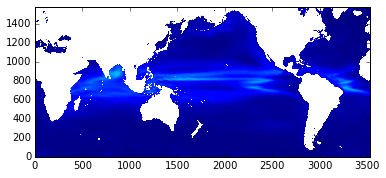

In [194]:
plt.imshow(N2_masked[10], origin='bottom')

In [ ]:
CTemp[mask_T[:]==True] = np.nan
CTemp_nan = CTemp

Salt_Abs[mask_T[:]==True] = np.nan
Salt_Abs_nan = Salt_Abs

In [ ]:
print type(N2_unmasked), type(CTemp_nan), type(Salt_Abs_nan)

<type 'numpy.ndarray'> <class 'numpy.ma.core.MaskedArray'> <class 'numpy.ma.core.MaskedArray'>


In [ ]:
from tempfile import TemporaryFile
POP_5059_N2 = TemporaryFile()
np.savez('POP_5059_N2', N2=N2_unmasked, mask_KMT=mask, mask_N2=mask_T[1:], Conserve_Temp=np.asarray(CTemp_nan), Abs_Salinity=np.asarray(Salt_Abs_nan))
POP_5059_N2.seek(0)

# npzfile = np.load('POP_5059_N2.npz')
# print npzfile.files
# N2 = np.ma.masked_array(npzfile['N2'], npzfile['mask_N2'])[:]

In [ ]:
Cori = gfd.f_coriolis(Lat)

In [ ]:
Dz = f.variables['dz'][:]*1e-2     # thickness of layer k
dz = f.variables['dzw'][1:]*1e-2  # midpoint of k to midpoint of k+1

In [ ]:
N2_masked[N2_masked.mask==True] = np.nan
N2_nan = N2_masked.copy()

Nu_1,Ny,Nx = N2_nan.shape
Nu_mat = np.ma.zeros((Ny,Nx))

for j in range(Ny):
    for i in range(Nx):
        for k in range(Nu_1):
            if np.isnan(N2_nan[k,j,i]) == True:
                if k > 0:
                    Nu_mat[j,i] = int(k)
                    break
                else:
                    Nu_mat[j,i] = np.nan
                    break
            else:
                Nu_mat[j,i] = k+1

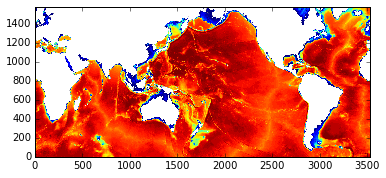

In [186]:
plt.figure()
plt.imshow(np.ma.masked_invalid(Nu_mat), origin='bottom')

In [ ]:
Barocli_def_Radii = np.ma.empty((Ny,Nx))
Barocli_def_Radii[:] = np.nan
Barocli_vec = np.ma.empty((Nu_1+1,Ny,Nx))
Barocli_vec[:] = np.nan

In [ ]:
for j in range(Ny):
    for i in range(Nx):
        if np.isnan(Nu_mat[j,i]) == False:
            H = int(Nu_mat[j,i])
            if np.isnan(H) == False:
                N2_H = N2_nan[:H,j,i]
#             print N
#             print len(N)
                f2 = Cori[j,i]**2
                Gamma = np.zeros((H+1,H+1))
                Gamma[0,0] = - f2*np.reciprocal(dz[0]*N2_H[0]*Dz[0])
                Gamma[0,1] = - Gamma[0,0].copy()
                Gamma[H,-1] = - f2*np.reciprocal(dz[-1]*N2_H[-1]*Dz[-2])
                Gamma[H,-2] = - Gamma[H,-1].copy()
#             print Gamma[0,0], Gamma[0,1], Gamma[H,-1], Gamma[H,-2]
                for k in range(1,H):
                    Gamma[k,k-1]  =  f2*np.reciprocal( dz[k]*N2_H[k-1]*Dz[k-1] )
                    Gamma[k,k+1]  =  f2*np.reciprocal( dz[k]*N2_H[k]*Dz[k] )
                    Gamma[k,k]  =  - ( Gamma[k,k-1].copy() + Gamma[k,k+1].copy() )
#                 print k, Gamma[k,k-1], Gamma[k,k], Gamma[k,k+1]
#                 print N[k-1], N[k]
            #if np.any(np.ma.masked_invalid(Gamma).mask) == True:
                #print np.ma.masked_invalid(Gamma).mask
            #Barocli_def_wavenum[j,i], Eigen_vec[:H,j,i] = linalg.eig(Gamma[:H,j,i])
                eigen_val, eigen_vec = linalg.eig(Gamma)
            # Sort the eigen values in ascending order
                eigen_id = np.argsort( eigen_val.real )[::-1]
                eigen_val = eigen_val[eigen_id]
                eigen_vec = eigen_vec[:,eigen_id]
#                 Barocli_def_wavenum[j,i] =  np.sqrt( -eigen_val.real[-2] )
                Barocli_def_Radii[j,i] = 2*np.pi*np.reciprocal(np.sqrt( -eigen_val.real[1] ))*1e-3
                Barocli_vec[:H+1,j,i] = eigen_vec[:,1]
            

In [ ]:
from tempfile import TemporaryFile
POP_1st_BarocliRadii = TemporaryFile()
np.savez('POP_1st_BarocliRadii', Radii=np.asarray(Barocli_def_Radii), modes=np.asarray(Barocli_vec))
POP_1st_BarocliRadii.seek(0)

<matplotlib.colorbar.Colorbar instance at 0x7f11c8af1b48>

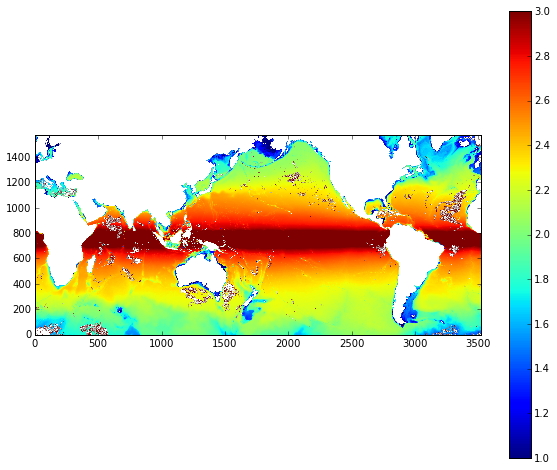

In [177]:
plt.figure(figsize=(10,8))
plt.imshow(np.ma.masked_array(np.log10(Barocli_def_Radii), mask), origin='bottom')
plt.clim([1,3])
plt.colorbar()

(2.649999999999999,
 358.75467560652584,
 -59.964214631430728,
 64.627476050950094)

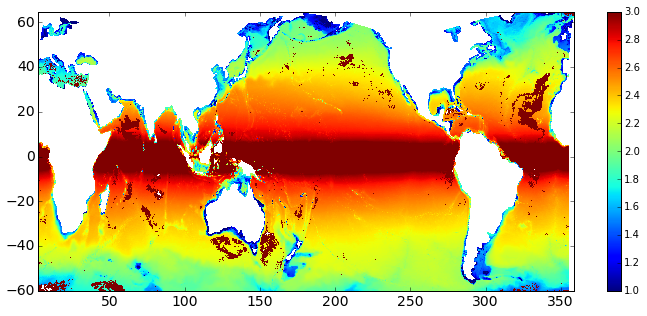

In [178]:
plt.figure(figsize=(12,5))
plt.pcolormesh(tlon[:-80], tlat[:-80], np.ma.masked_invalid(np.ma.masked_array(np.log10(Barocli_def_Radii[:-80]), mask[:-80])))
plt.clim([1,3])
plt.colorbar()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.axis('tight')

In [179]:
print Barocli_def_Radii.shape

(1578, 3523)


In [180]:
dlat, dlon = (10., 10.)
Degx, Degy = (int((lon_end-lon_start)/dlon), int((lat_end-lat_start)/dlat))
# lon_global = np.arange(lon_start, lon_end+2*dlon, dlon)
# lat_global = np.arange(lat_start, lat_end+2*dlat, dlat)
# Lon_global, Lat_global = np.meshgrid(lon_global, lat_global)
Barocli_def_Radii_mean = np.zeros((Degy+1,Degx+1)) 

In [205]:
crit = 0.01
j,i = (0,0)
west, south = (lon_start, lat_start)
east, north = (west+dlon, south+dlat)
masked_Barocli_def_Radii = Barocli_def_Radii.copy()
masked_Barocli_def_Radii[ np.abs(masked_Barocli_def_Radii) > 1e4 ] = np.nan
#nanarray = numpy.zeros(N)
#nanarray[:] = numpy.NAN

while south < lat_end+dlat:
    west = lon_start
    east = west+dlon
    i = 0
    while west < lon_end+dlon:

        lonrange = np.array([west,east])
        latrange = np.array([south,north])
        lonmask = (tlon >= lonrange[0]) & (tlon < lonrange[1])
        latmask = (tlat >= latrange[0]) & (tlat < latrange[1])
        boxidx = lonmask & latmask  # this won't necessarily be square
        irange = np.where(boxidx.sum(axis=0))[0]
        imin, imax = irange.min(), irange.max()
        jrange = np.where(boxidx.sum(axis=1))[0]
        jmin, jmax = jrange.min(), jrange.max()
            #print imin, imax, jmin, jmax
        
        
        region_mask = mask[jmin:jmax, imin:imax]
        Ny, Nx = region_mask.shape
        land_fraction = region_mask.sum().astype('f8') / (Ny*Nx)
            #SSH_domain = SSH[..., jmin:jmax, imin:imax]

    
        if south < lat_end+dlat:
            if west < lon_end+dlon:
                if land_fraction<crit:
                    Barocli_def_Radii_mean[j,i] = np.nanmean( masked_Barocli_def_Radii[jmin:jmax, imin:imax] )       
                    if j == 0:
                        print west, east
                else:
                    Barocli_def_Radii_mean[j,i] = np.nan
        west = east
        east = west+dlon
        i += 1
    
    south = north
    north = south+dlat
    j += 1

5.0 15.0
15.0 25.0
25.0 35.0
35.0 45.0
45.0 55.0
55.0 65.0
65.0 75.0
75.0 85.0
85.0 95.0
95.0 105.0
105.0 115.0
115.0 125.0
125.0 135.0
135.0 145.0
145.0 155.0
155.0 165.0
165.0 175.0
175.0 185.0
185.0 195.0
195.0 205.0
205.0 215.0
215.0 225.0
225.0 235.0
235.0 245.0
245.0 255.0
255.0 265.0
265.0 275.0
275.0 285.0
305.0 315.0
315.0 325.0
325.0 335.0
335.0 345.0
345.0 355.0


In [206]:
print Barocli_def_Radii_mean[0,4], Barocli_def_Radii_mean[0,5], Barocli_def_Radii_mean[0,6]

82.1521102454 85.4566486806 71.0296999013


In [6]:
fname = 'psd_slope_SSH_Global.mat'
f_psd_slope = io.loadmat(fname)
Lon = f_psd_slope['Lon']
Lat = f_psd_slope['Lat']

print Lon.shape

(13, 36)


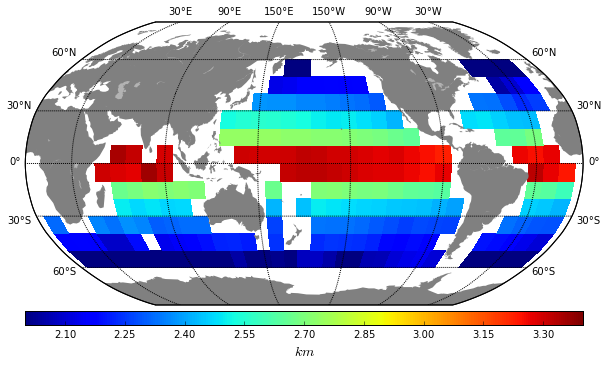

In [208]:
from mpl_toolkits.basemap import Basemap
m = Basemap(projection='robin', lon_0=180)
fig = plt.figure(figsize=(10,6))
axi = fig.add_subplot(111)
m.fillcontinents(color='0.5', lake_color='0.7')
m.drawmapboundary(fill_color='none')

x,y = m(Lon,Lat)
pc = m.pcolormesh(x, y, np.ma.masked_invalid(np.log10(Barocli_def_Radii_mean)), cmap='jet')
pc.set_clim([2.,3.4])
m.drawparallels(range(-60,61,30), labels=[1,1,0,0]);
m.drawmeridians(range(30,360,60), labels=[0,0,1,1]);
cbar = m.colorbar(pc, location='bottom')
cbar.set_label('$km$', fontsize=14)

In [209]:
from tempfile import TemporaryFile
POP_1st_BarocliRadii_10deg = TemporaryFile()
np.savez('POP_1st_BarocliRadii_10deg', Radii=np.asarray(Barocli_def_Radii_mean), Lon=Lon, Lat=Lat)
POP_1st_BarocliRadii_10deg.seek(0)

['Radii', 'modes']
['arr_1', 'arr_0']


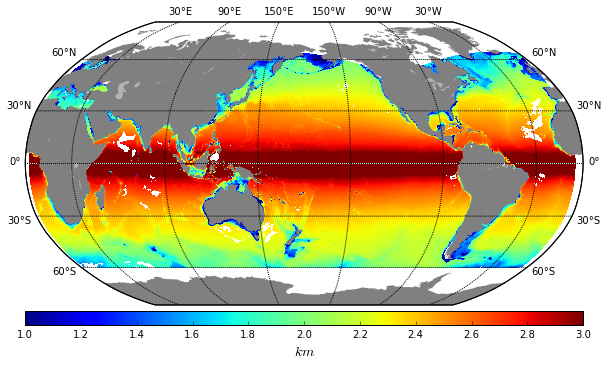

In [17]:
npzfile = np.load('POP_1st_BarocliRadii.npz')
print npzfile.files
Radii = npzfile['Radii']
masked_Barocli_def_Radii = Radii.copy()
masked_Barocli_def_Radii[ np.abs(masked_Barocli_def_Radii) > 1e4 ] = np.nan

npzfile = np.load('interpLatnLon.npz')
print npzfile.files
tlat = npzfile['arr_0']
tlon = npzfile['arr_1']

from mpl_toolkits.basemap import Basemap
m = Basemap(projection='robin', lon_0=180)
fig = plt.figure(figsize=(10,6))
axi = fig.add_subplot(111)
m.fillcontinents(color='0.5', lake_color='0.7')
m.drawmapboundary(fill_color='none')

x,y = m(tlon,tlat)
pc = m.pcolormesh(x[:-80], y[:-80], np.ma.masked_invalid(np.log10(masked_Barocli_def_Radii[:-80])), cmap='jet')
pc.set_clim([1.,3.])
m.drawparallels(range(-60,61,30), labels=[1,1,0,0]);
m.drawmeridians(range(30,360,60), labels=[0,0,1,1]);
cbar = m.colorbar(pc, location='bottom')
cbar.set_label('$km$', fontsize=14)
plt.savefig('Barocli_def_radii_Robin.png')

['Radii', 'modes']
['arr_1', 'arr_0']
['Lat', 'Radii', 'Lon']


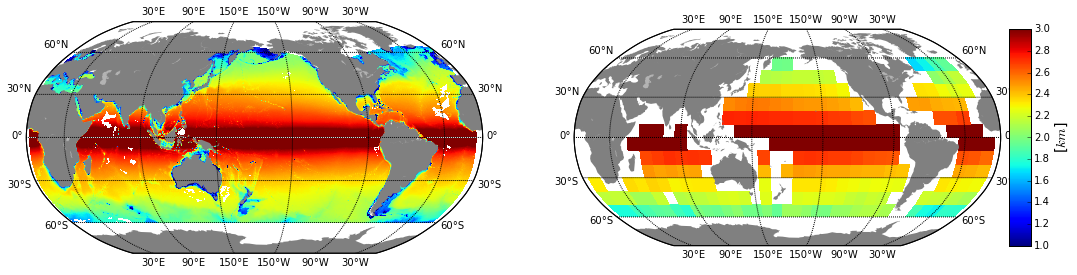

In [24]:
npzfile = np.load('POP_1st_BarocliRadii.npz')
print npzfile.files
Radii = npzfile['Radii']
masked_Barocli_def_Radii = Radii.copy()
masked_Barocli_def_Radii[ np.abs(masked_Barocli_def_Radii) > 1e4 ] = np.nan

npzfile = np.load('interpLatnLon.npz')
print npzfile.files
tlat = npzfile['arr_0']
tlon = npzfile['arr_1']

npzfile = np.load('POP_1st_BarocliRadii_10deg.npz')
print npzfile.files
Radii_10 = npzfile['Radii']
Lon10 = npzfile['Lon']
Lat10 = npzfile['Lat']

from mpl_toolkits.basemap import Basemap
m = Basemap(projection='robin', lon_0=180)
fig = plt.figure(figsize=(18,7))
axi = fig.add_subplot(121)
m.fillcontinents(color='0.5', lake_color='0.7')
m.drawmapboundary(fill_color='none')

x,y = m(tlon,tlat)
pc = m.pcolormesh(x[:-80], y[:-80], np.ma.masked_invalid(np.log10(masked_Barocli_def_Radii[:-80])), cmap='jet')
pc.set_clim([1.,3.])
m.drawparallels(range(-60,61,30), labels=[1,1,0,0]);
m.drawmeridians(range(30,360,60), labels=[0,0,1,1]);
#cbar = m.colorbar(pc, location='bottom')
#cbar.set_label('$km$', fontsize=14)

axi = fig.add_subplot(122)
m.fillcontinents(color='0.5', lake_color='0.7')
m.drawmapboundary(fill_color='none')

x10,y10 = m(Lon10,Lat10)
pc = m.pcolormesh(x10, y10, np.ma.masked_invalid(np.log10(Radii_10)), cmap='jet')
pc.set_clim([1.,3.])
m.drawparallels(range(-60,61,30), labels=[1,1,0,0]);
m.drawmeridians(range(30,360,60), labels=[0,0,1,1]);
cbar = m.colorbar(pc, location='right')
cbar.set_label('[$km$]', fontsize=14)

plt.savefig('Barocli_def_radii_Robin_subplot.png', bbox_inches='tight')